In [1]:
import sys
import os

# Add project root to Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

### Create Synthetic Cases

In [3]:
# Create synthetic cases
import data.synthetic_cases as synthetic_cases

# Single circle in the center of the image
data_single_circle = synthetic_cases.create_circle_mask((256, 256), 32)

# Two circles with different radii
data_paired_circles = synthetic_cases.create_paired_circles((256, 256), (32, 16), shift_x=25)




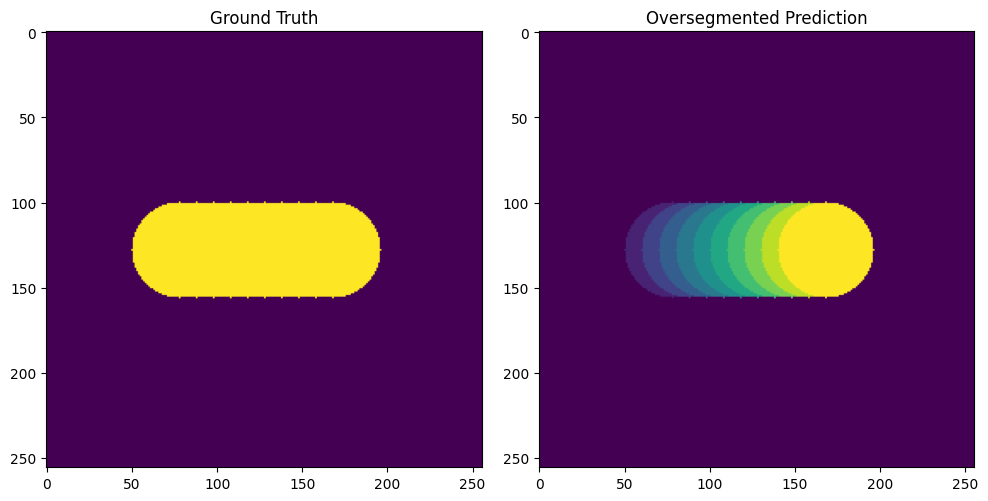

In [48]:
gt = synthetic_cases.create_circle_mask((256, 256), radius=30, center=(128, 128))
pred = synthetic_cases.create_n_oversegments_from_circle(gt, n=10, offset=10)



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pred>0)
plt.title('Ground Truth')
plt.subplot(1, 2, 2)
plt.imshow(pred)
plt.title('Oversegmented Prediction')
plt.tight_layout()
plt.show()


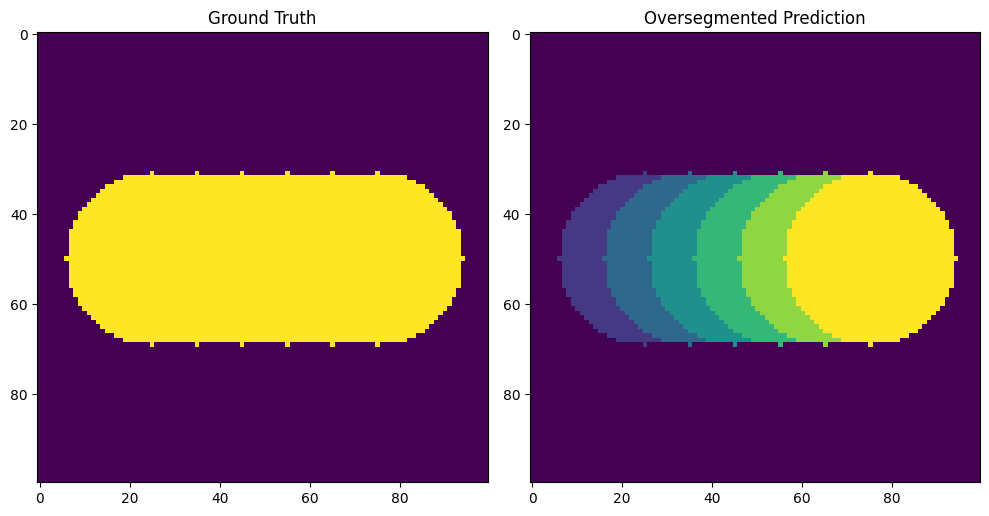

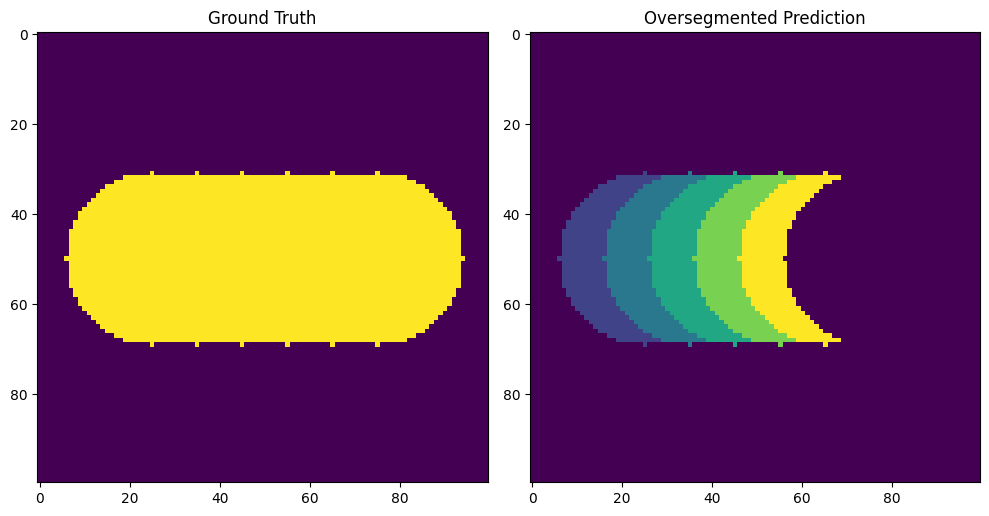

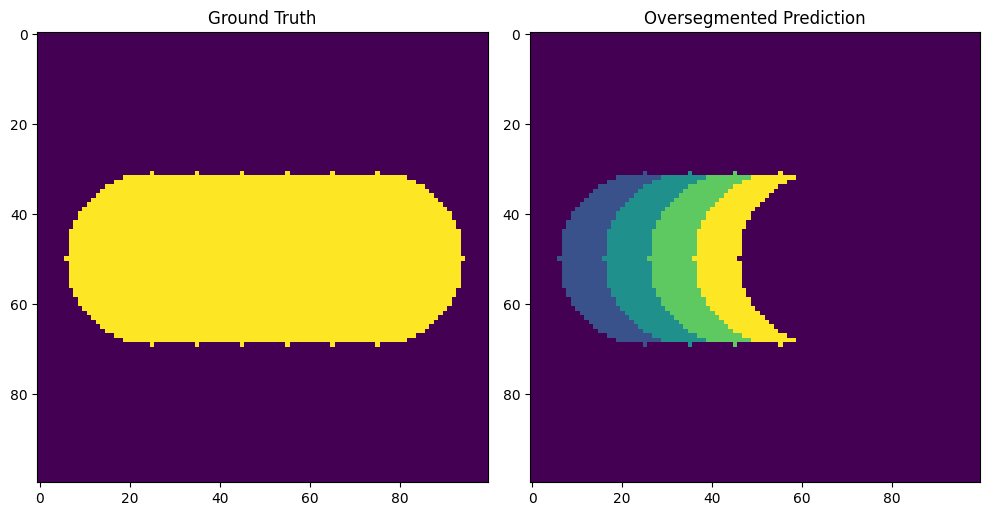

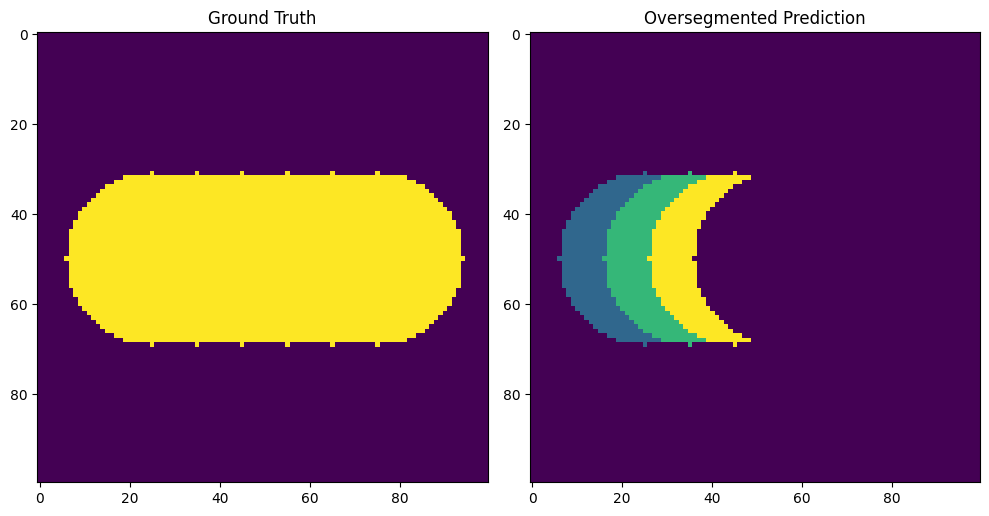

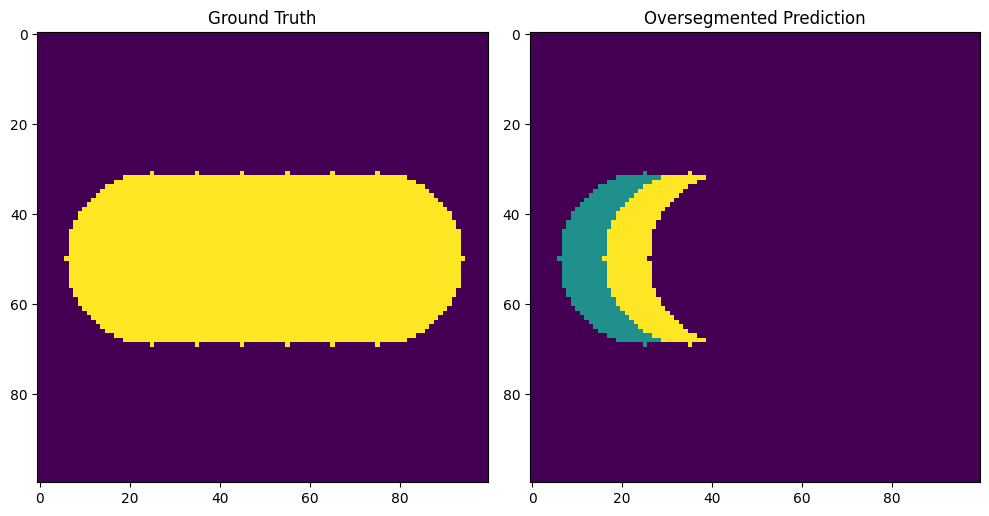

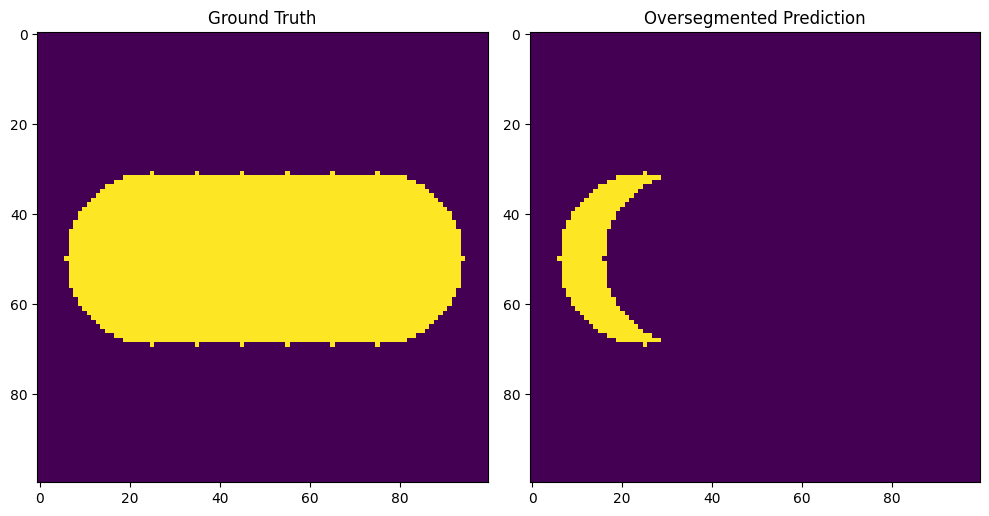

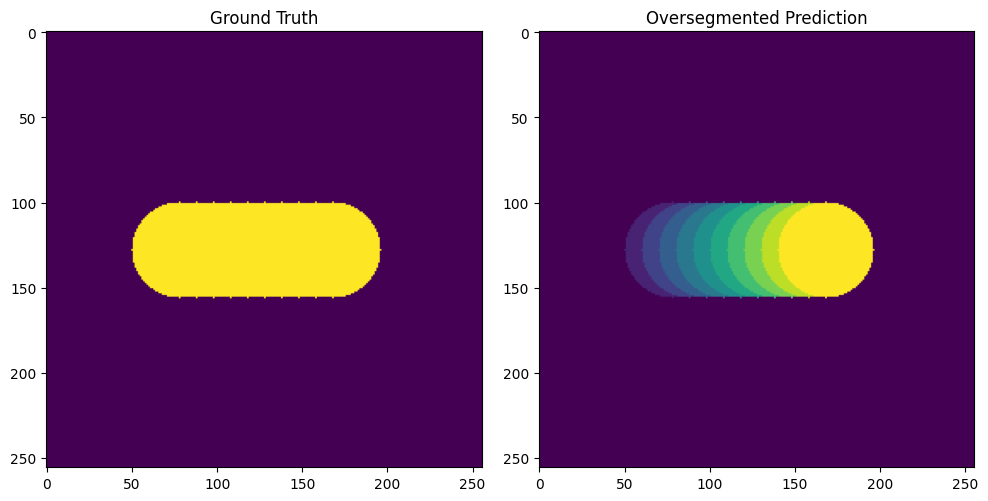

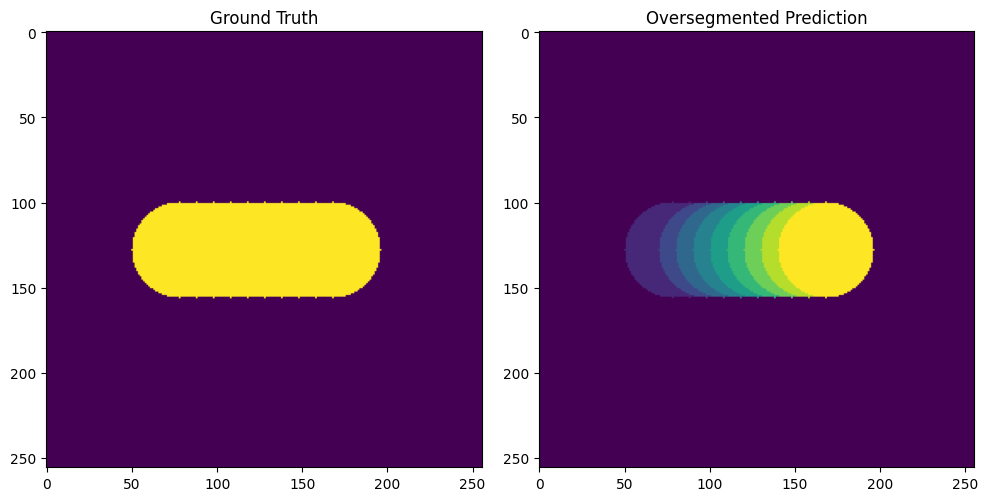

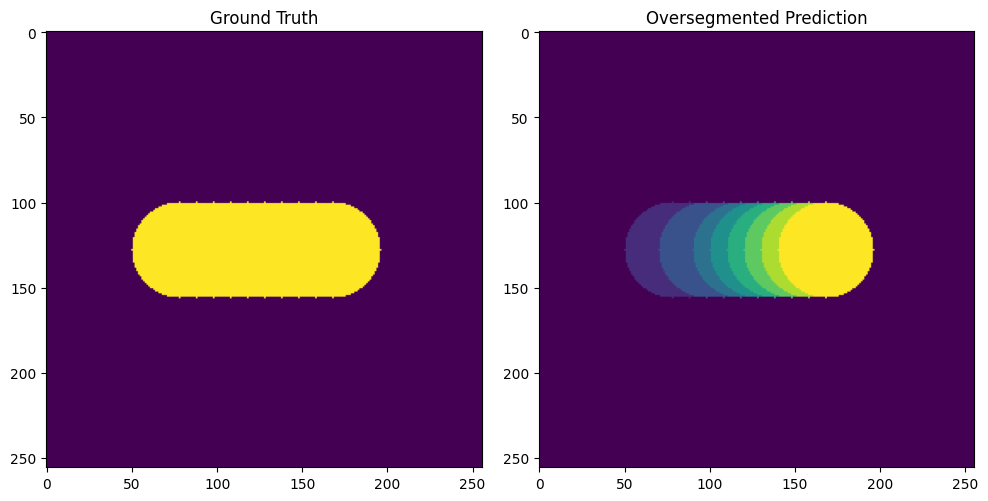

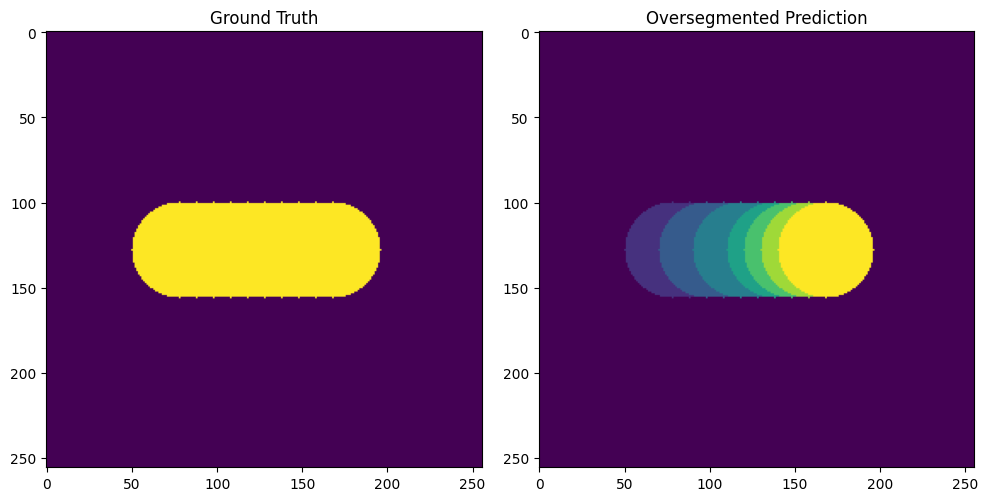

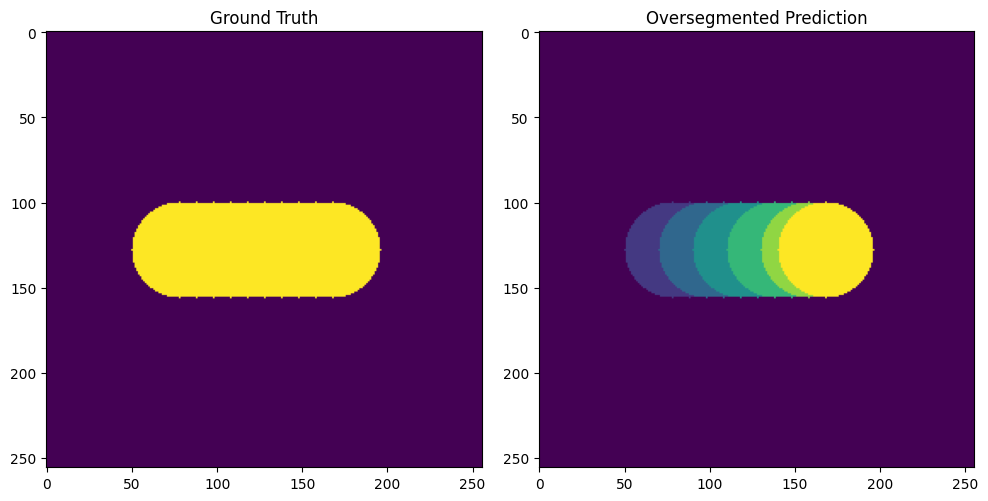

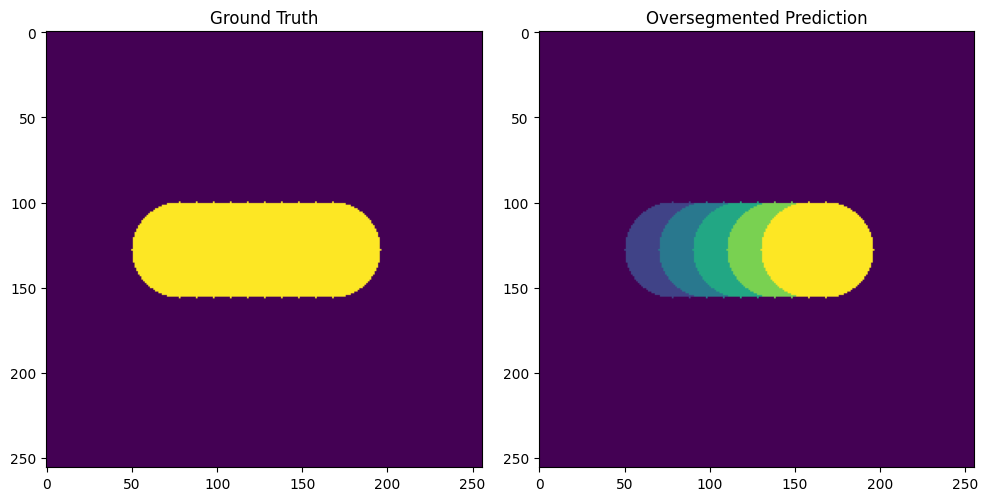

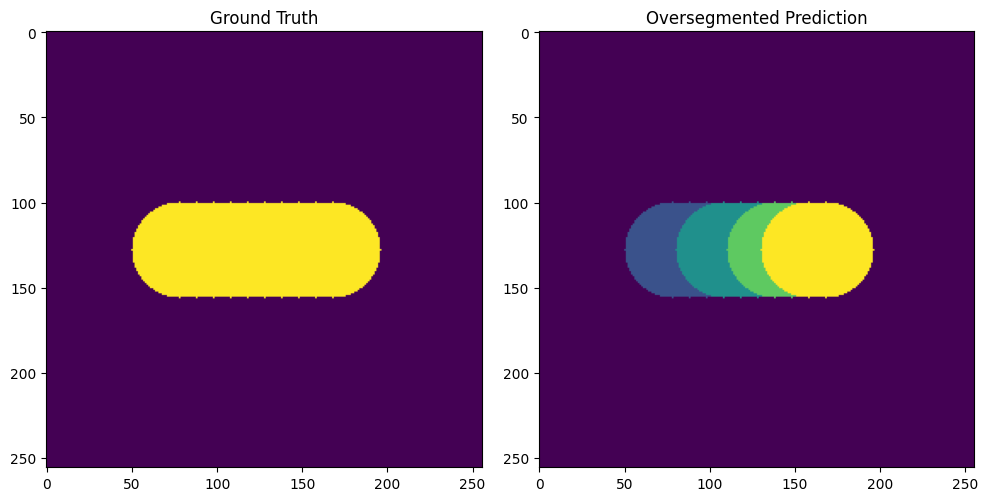

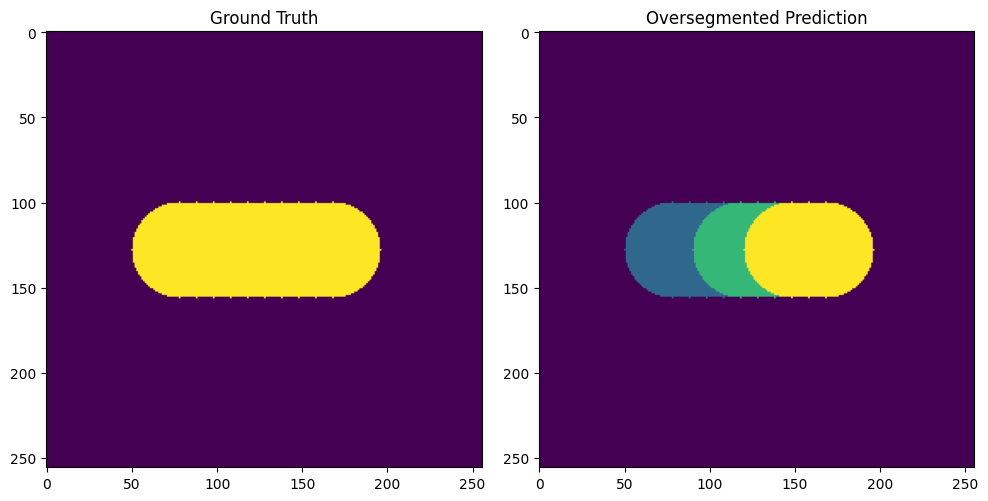

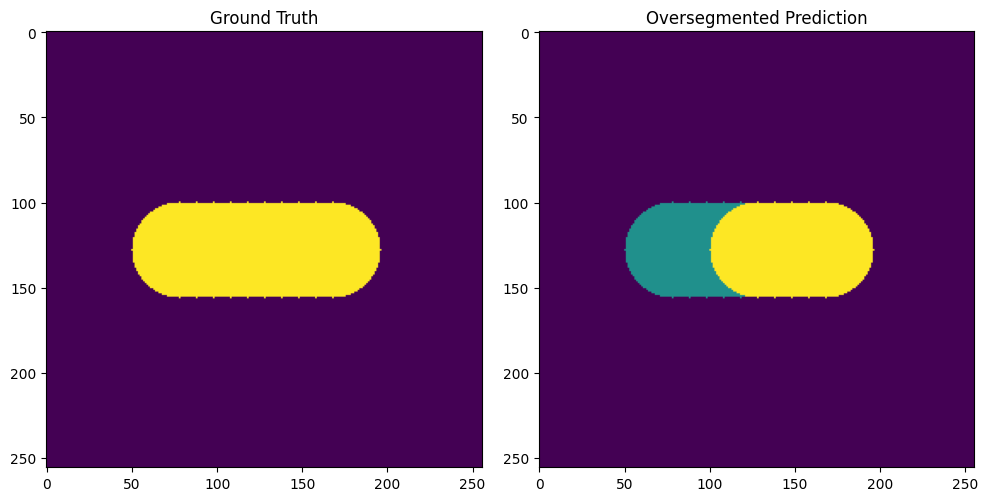

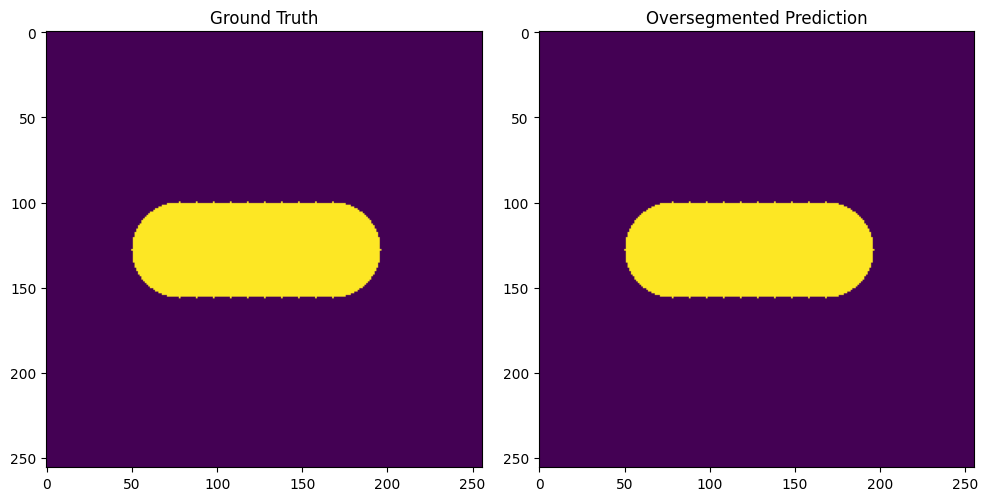

In [50]:
def relabel_segments_fixed_groups(img: np.ndarray, k: int) -> np.ndarray:
    """
    Relabel the input mask into `k` groups by evenly distributing the original labels.

    Args:
        img (np.ndarray): Input mask with original labels (e.g., 1–6).
        k (int): Desired number of output segments (e.g., 2, 3, ..., 6).

    Returns:
        np.ndarray: New predicted mask with `k` segment labels (1 to k), covering all original pixels.
    """
    pred = np.zeros_like(img, dtype=np.uint8)
    labels = np.unique(img)
    labels = labels[labels > 0]  # skip background

    # Split labels into k nearly equal groups
    groups = np.array_split(labels, k)

    for new_label, group in enumerate(groups, start=1):
        for original_label in group:
            pred[img == original_label] = new_label

    return pred


def evaluate_oversegmentation_by_merging_segments(img: np.ndarray, k_range=range(6, 0, -1)):
    for k in k_range:
        pred = relabel_segments_fixed_groups(img, k)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(pred>0)
        plt.title('Ground Truth')
        
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.title('Oversegmented Prediction')
        plt.tight_layout()
        plt.show()

evaluate_oversegmentation_by_merging_segments(pred, k_range=range(10,0,-1))

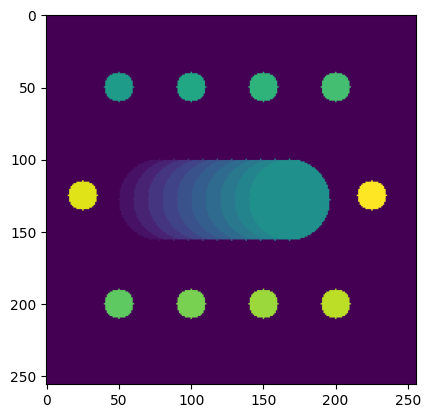

In [63]:
pred_2 = pred.copy()
centers = np.array([(50,50), (100,50), (150,50), (200,50), (50,200), (100,200), (150,200), (200,200), (25, 125), (225, 125)])
i = 11
for center in centers:
    circle_mask = i*synthetic_cases.create_circle_mask((256, 256), 10, center=center)
    pred_2 = pred_2+circle_mask
    i+=1

plt.imshow(pred_2)

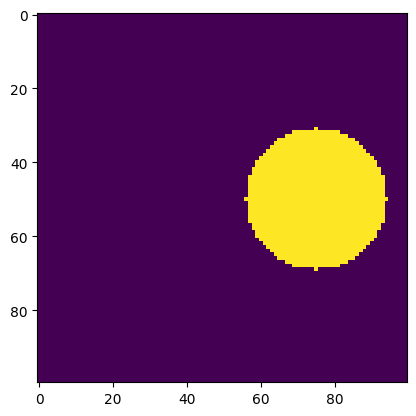

In [39]:
plt.imshow(pred==6)

### Erosion Test

In [5]:
# Create a paired circles and erode progressively with circular structuring element to check robustness
import metrics.core as metrics
import metrics.utils as utils

ground_truth = data_paired_circles
predicted_mask = data_paired_circles

for i in range(1, 10):
    print(metrics.evaluate_segmentation(ground_truth, predicted_mask))
    predicted_mask = utils.erode_dilate_mask(predicted_mask, operation='erode')

{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 2, 'fn': 0, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'accuracy': np.float64(1.0), 'f1': np.float64(1.0), 'n_true': 2, 'n_pred': 2, 'mean_true_score': np.float32(1.0), 'mean_matched_score': np.float32(1.0), 'panoptic_quality': np.float32(1.0)}
{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 2, 'fn': 0, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'accuracy': np.float64(1.0), 'f1': np.float64(1.0), 'n_true': 2, 'n_pred': 2, 'mean_true_score': np.float32(0.9167), 'mean_matched_score': np.float32(0.9167), 'panoptic_quality': np.float32(0.9167)}
{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 2, 'fn': 0, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'accuracy': np.float64(1.0), 'f1': np.float64(1.0), 'n_true': 2, 'n_pred': 2, 'mean_true_score': np.float32(0.8366), 'mean_matched_score': np.float32(0.8366), 'panoptic_quality': np.float32(0.8366)}
{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 2

### Dilation test

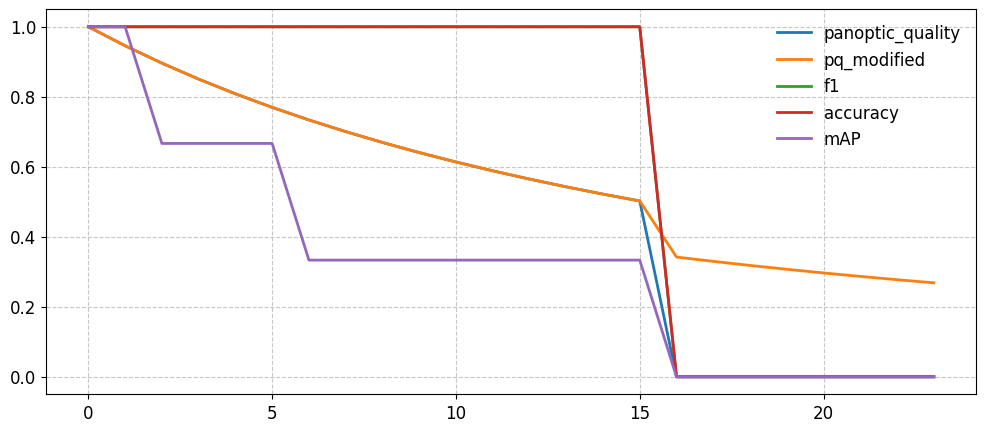

In [28]:
# Create a paired circles and erode progressively with circular structuring element to check robustness
import metrics.core as metrics
import metrics.utils as utils
import pandas as pd

ground_truth = data_single_circle
predicted_mask = data_single_circle

scores = []

for i in range(1, 25):
    score = metrics.evaluate_segmentation(ground_truth, predicted_mask)
    pq_modified = metrics._proposed_sqrt(ground_truth, predicted_mask)
    mAP = metrics.average_precision(ground_truth, predicted_mask)[0].mean()
    predicted_mask = utils.erode_dilate_mask(predicted_mask, operation='dilate', kernel_size=1)

       

    # Add the scores into a dict with keys as criteria and values as score
    scores.append({
        'criterion': score['criterion'],
        'thresh': score['thresh'],
        'fp': score['fp'],
        'tp': score['tp'],
        'fn': score['fn'],
        'precision': score['precision'],
        'recall': score['recall'],
        'f1': score['f1'],
        'accuracy': score['accuracy'],
        'n_true': score['n_true'],
        'n_pred': score['n_pred'],
        'mean_matched_score': score['mean_matched_score'],
        'panoptic_quality': score['panoptic_quality'],
        'pq_modified': pq_modified,
        'mAP': mAP
    })

scores_df = pd.DataFrame(scores)

# Plot the scores
plt.plot(scores_df.panoptic_quality, label='panoptic_quality')
plt.plot(scores_df.pq_modified, label='pq_modified')
plt.plot(scores_df.f1, label='f1')
plt.plot(scores_df.accuracy, label='accuracy')
plt.plot(scores_df.mAP, label='mAP')
plt.legend()
plt.show()


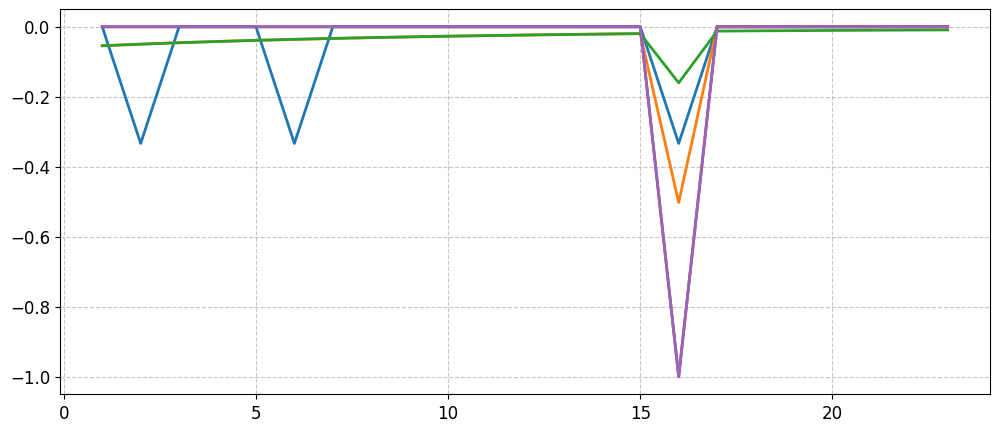

In [29]:
# Plot progressive difference between rows
plt.plot(scores_df.mAP - scores_df.mAP.shift(1), label='mAP')
plt.plot(scores_df.panoptic_quality - scores_df.panoptic_quality.shift(1), label='panoptic_quality')
plt.plot(scores_df.pq_modified - scores_df.pq_modified.shift(1), label='pq_modified')
plt.plot(scores_df.f1 - scores_df.f1.shift(1), label='f1')
plt.plot(scores_df.accuracy - scores_df.accuracy.shift(1), label='accuracy')
# plt.legend()
plt.show()

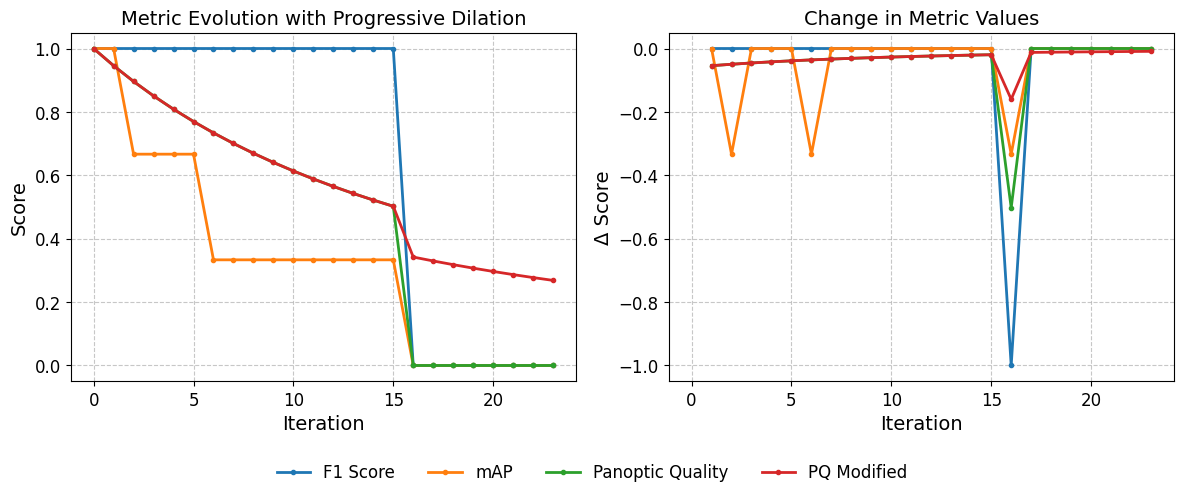

In [32]:
import matplotlib.pyplot as plt

# Updated order: F1, mAP, Panoptic Quality, PQ Modified
metric_order = ['F1 Score', 'mAP', 'Panoptic Quality', 'PQ Modified']
metrics_to_plot = {
    'F1 Score': scores_df.f1,
    'mAP': scores_df.mAP,
    'Panoptic Quality': scores_df.panoptic_quality,
    'PQ Modified': scores_df.pq_modified
}

# Assign specific colors: emphasize PQ Modified
custom_colors = {
    'F1 Score': '#1f77b4',        # blue
    'mAP': '#ff7f0e',             # orange
    'Panoptic Quality': '#2ca02c', # green
    'PQ Modified': '#d62728'      # red (emphasis)
}

plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (12, 5),
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.7,
    'legend.frameon': False
})

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

# Left plot: metric values
for name in metric_order:
    axes[0].plot(metrics_to_plot[name], label=name, color=custom_colors[name], marker='.')

axes[0].set_title('Metric Evolution with Progressive Dilation')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Score')

# Right plot: delta values
for name in metric_order:
    axes[1].plot(metrics_to_plot[name].diff(), label=name, color=custom_colors[name], marker='.')

axes[1].set_title('Change in Metric Values')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Δ Score')

# Remove legends from individual plots
axes[0].legend().remove()
axes[1].legend().remove()

# Shared legend below
fig.legend(metric_order, loc='lower center', ncol=len(metric_order), bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)
plt.show()

### Ignore Tests

In [11]:
import metrics.core as metrics

print(metrics.evaluate_segmentation(data_single_circle, data_single_circle))

print(metrics.evaluate_segmentation(data_paired_circles, data_paired_circles))

print(metrics.evaluate_segmentation(data_single_circle, data_paired_circles))


{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 1, 'fn': 0, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'accuracy': np.float64(1.0), 'f1': np.float64(1.0), 'n_true': 1, 'n_pred': 1, 'mean_true_score': np.float32(1.0), 'mean_matched_score': np.float32(1.0), 'panoptic_quality': np.float32(1.0)}
{'criterion': 'iou', 'thresh': 0.5, 'fp': 0, 'tp': 2, 'fn': 0, 'precision': np.float64(1.0), 'recall': np.float64(1.0), 'accuracy': np.float64(1.0), 'f1': np.float64(1.0), 'n_true': 2, 'n_pred': 2, 'mean_true_score': np.float32(1.0), 'mean_matched_score': np.float32(1.0), 'panoptic_quality': np.float32(1.0)}
{'criterion': 'iou', 'thresh': 0.5, 'fp': 2, 'tp': 0, 'fn': 1, 'precision': np.int64(0), 'recall': np.int64(0), 'accuracy': np.int64(0), 'f1': np.int64(0), 'n_true': 1, 'n_pred': 2, 'mean_true_score': np.float32(0.0), 'mean_matched_score': np.float64(0.0), 'panoptic_quality': np.float32(0.0)}


In [ ]:
import metrics.core as metrics

print(metrics._proposed_sqrt(data_single_circle, data_single_circle))

print(metrics._proposed_sqrt(data_paired_circles, data_paired_circles))

print(metrics._proposed_sqrt(data_single_circle, data_paired_circles))


1.0
1.0
0.31631858014964914


In [9]:
import metrics.core as metrics

metrics.evaluate_segmentation(data_single_circle, data_paired_circles)

{'criterion': 'iou',
 'thresh': 0.5,
 'fp': 2,
 'tp': 0,
 'fn': 1,
 'precision': np.int64(0),
 'recall': np.int64(0),
 'accuracy': np.int64(0),
 'f1': np.int64(0),
 'n_true': 1,
 'n_pred': 2,
 'mean_true_score': np.float32(0.0),
 'mean_matched_score': np.float64(0.0),
 'panoptic_quality': np.float32(0.0)}